In [1]:
import pickle
import numpy as np
import heatmaps
# from animated_plots import animateFFTRange, animateRangeHeatmap, animateDopplerRangeHeatmap, animateAzimuthRangeHeatmap
from fourier import rangeFFT, angleFFT, dopplerFFT
from params import PARAMS
from raw_signal import RadarData, plot_signal
import matplotlib.pyplot as plt
from time import sleep as sleep
from IPython.display import display, clear_output

Slope 166000000000000.0
Bandwith 3984.0 GHz
Minimum Frame Periodicity: 11.904000000000002 ms
Chirps Per Frame: 384
Num Range Bins: 256
Range Resolution: 0.03762455547188755 m
Max Unambiguous Range: 8.668697580722892 m
Num Doppler Bins: 128
Doppler Resolution: 0.20986815216173832 m/s
Max Doppler: 13.431561738351252 m/s
Num Azimuth Bins: 64
Num Elevation Bins: 32


Text(0, 0.5, 'Doppler (m/s)')

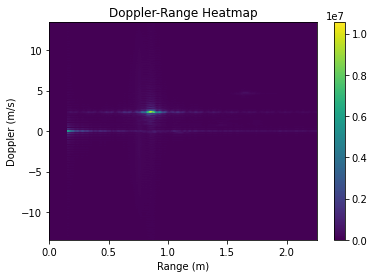

In [2]:
# Load data from file
data = pickle.load(open('data/openradar_25-01-23_QMUL-MCR.dat', 'rb'))
# Configure playback mode
config = data['config']
PARAMS.set_playback_mode(config)
# Read main parameters
rdata = RadarData(device='IWR6843ISK-ODS',
                  tx=PARAMS.TX_ANTENNAS,
                  rx=PARAMS.RX_ANTENNAS,
                  loops=PARAMS.CHIRP_LOOPS,
                  samples=PARAMS.ADC_SAMPLES)

# Get data frame
frames = data['data']
# Choose frame
adc_data = frames[2]
# Set RadarData raw_data
rdata.raw_data = adc_data
# Access data separated by Rx and Tx antennas
v_array = rdata.separated_vx_data
## Doppler FFT
[dFFT, dBins, rBins] = dopplerFFT(v_array)

fig, ax = plt.subplots()
c = ax.pcolormesh(rBins[0:60*8], dBins, dFFT[:,0:60*8])
fig.colorbar(c, ax=ax)
ax.set_title('Doppler-Range Heatmap')
ax.set_xlabel('Range (m)')
ax.set_ylabel('Doppler (m/s)')


In [5]:
a = rBins[0:60*4]

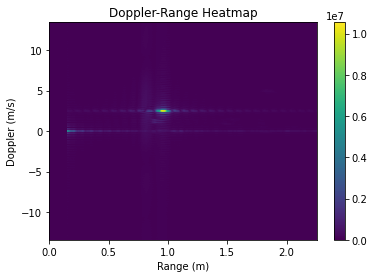

In [3]:
for n in range(np.size(frames,0)):
    # Choose frame
    adc_data = frames[n]
    # Set RadarData raw_data
    rdata.raw_data = adc_data
    # Access data separated by Rx and Tx antennas
    v_array = rdata.separated_vx_data
    ## Doppler FFT
    [dFFT, dBins, rBins] = dopplerFFT(v_array)
    c.set_array(dFFT[:,:60*8])
    # plt.show()
    # fig.savefig('images/doppler'+str(n))
    display(fig)
    clear_output(wait = True)
    plt.pause(0.01)

In [ ]:
## 1D RANGE FFT and radar cube
[RC, rFFT, rBins] = rangeFFT(v_array[1,:,:],rdata.device)
# The range profile can be extracted from this as
# plt.plot(rBins[8:],np.mean(abs(rFFT),axis=0)[8:])
# plt.show()

In [ ]:
## 2D AZIMUTH & ELEVATION FFTs
[aFFT, eFFT, aBins, eBins] = angleFFT(RC)

In [ ]:
# Polar heatmaps
# heatmaps.plotAzimuthRangeHeatmap(rBins[:80],aBins[1:],aFFT[1:,:80])
# heatmaps.plotElevationRangeHeatmap(rBins[:80],eBins[1:],eFFT[1:,:80])
# Cartesian HEATMAP
# heatmaps.plotXYheatmap(rBins[:60],aBins[1:],aFFT[1:,:60])

In [ ]:
## Doppler FFT
[dFFT, dBins, rBins] = dopplerFFT(v_array)

heatmaps.plotDopplerRangeHeatmap(rBins[:60],dBins,abs(dFFT[:,:60]))